In [1]:
import drjit as dr
import mitsuba as mi
import numpy as np
import csv
from sklearn.metrics import r2_score
#mi.set_variant("cuda_ad_mono")
mi.set_variant("cuda_ad_spectral")

[mitsuba] Warning: Couldn't import the ipywidgets package. Installing this package is required for the system to properly log messages and print in Jupyter notebooks!


In [ ]:
scene = mi.load_file('./Parameters/_scenefile/inverse_threelayer_allband.xml')
#image_ref could be the reference from other models or the measured reference images

#image_ref = mi.render(scene)
# Preview the reference image
#mi.util.convert_to_bitmap(image_ref)

Iteration 1199: loss error= [186.98231506347656], parameter error = 0.296933 
Optimization complete.


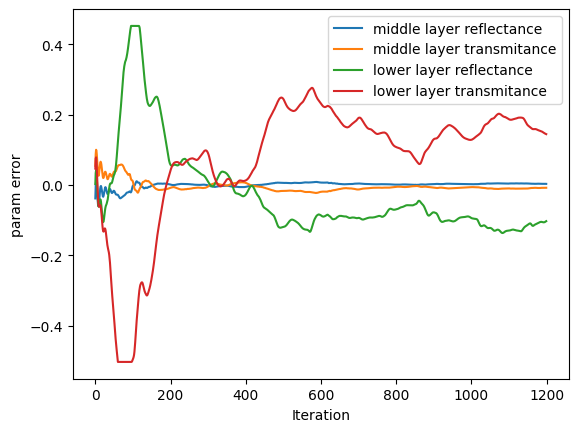

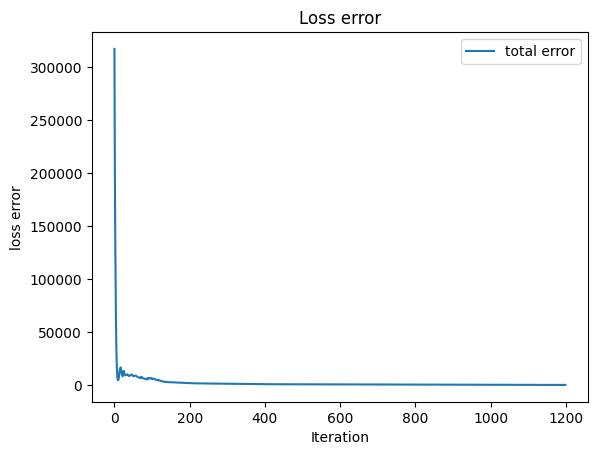

ref: [0.07569999992847443, 0.14419999718666077, 0.08259999752044678, 0.41200000047683716] [0.012500000186264515, 0.11999999731779099, 0.017500000074505806, 0.5047000050544739] [0.08060000091791153, 0.16670000553131104, 0.08919999748468399, 0.4528999924659729] [0.009200000204145908, 0.12139999866485596, 0.01209999993443489, 0.4968000054359436]
inverse: [0.07575555890798569, 0.14420856535434723, 0.08261837065219879, 0.40861642360687256] [0.010196458548307419, 0.11979985237121582, 0.01686074584722519, 0.512398898601532] [0.08049680292606354, 0.16673952341079712, 0.08915900439023972, 0.5555540919303894] [0.034346845000982285, 0.12444432824850082, 0.01881560869514942, 0.35191959142684937]
rmse 0.012626201367985786
r2 0.8597492183489459
relativeerror(abs) 0.7299125678402301


In [3]:

def mse(image):
    return dr.mean(dr.sqr(image - image_ref))*1e8

def mse1(image1,image2):
    return dr.mean((image1-image_ref)*(image2-image_ref))

def iterate():
    params = mi.traverse(scene)
    #key1 = 'leaf1.reflectance.values'
    #key2 = 'leaf1.transmittance.values'
    key3 = 'leaf2.reflectance.values'
    key4 = 'leaf2.transmittance.values'
    key5 = 'leaf3.reflectance.values'
    key6 = 'leaf3.transmittance.values'
    #key5 = 'soil.brdf_1.reflectance.value'

    # Save the original value
    #param1_ref = mi.Float(params[key1])
    #param2_ref = mi.Float(params[key2])
    param3_ref = mi.Float(params[key3])
    param4_ref = mi.Float(params[key4])
    param5_ref = mi.Float(params[key5])
    param6_ref = mi.Float(params[key6])

    # Set another color value and update the scene
    #params[key1] = mi.Float([0.5,0.5,0.5,0.5])
    #params[key2] = mi.Float([0.5,0.5,0.5,0.5])
    params[key3] = mi.Float([0.5,0.5,0.5,0.5])
    params[key4] = mi.Float([0.5,0.5,0.5,0.5])
    params[key5] = mi.Float([0.5,0.5,0.5,0.5])
    params[key6] = mi.Float([0.5,0.5,0.5,0.5])
    #params[key5] = dr.cuda.Float(0.1)
    params.update();
    #print(param1_ref,param2_ref,param3_ref,param4_ref)
    #print(params[key1],params[key2],params[key3],params[key4])

    #temp1=dr.enable_grad(params[key1])
    #temp2=dr.enable_grad(params[key2])
    temp1=dr.enable_grad(params[key3])
    temp2=dr.enable_grad(params[key4])
    temp1=dr.enable_grad(params[key5])
    temp2=dr.enable_grad(params[key6])
    image_init = mi.render(scene, params)

    opt = mi.ad.Adam(lr=0.05)
    #opt[key1] = params[key1]
    #opt[key2] = params[key2]
    opt[key3] = params[key3]
    opt[key4] = params[key4]
    opt[key5] = params[key5]
    opt[key6] = params[key6]
    opt.set_learning_rate({key3:0.05,key4:0.05,key5:0.05,key6:0.05})
    #opt[key5] = params[key5]
    params.update(opt);

    iteration_count = 1000
    totalerrors = []
    #parameter1errors = np.empty(shape=(1,4))
    #parameter2errors = np.empty(shape=(1,4))
    parameter3errors = np.empty(shape=(1,4))
    parameter4errors = np.empty(shape=(1,4))
    parameter5errors = np.empty(shape=(1,4))
    parameter6errors = np.empty(shape=(1,4))
    lossarr=[]
    for it in range(iteration_count):
        # Perform a (noisy) differentiable rendering of the scene
        image = mi.render(scene, params)
        #image1 =mi.render(scene, params)
        #loss =mse1(image,image1)
        # Evaluate the objective function from the current rendered image
        loss = mse(image)

        # Backpropagate through the rendering process
        dr.backward(loss)

        # Optimizer: take a gradient descent step
        opt.step()

        # Post-process the optimized parameters to ensure legal color values.
        #opt[key1] = dr.clamp(opt[key1], 0.0001, 1.0)
        #opt[key2] = dr.clamp(opt[key2], 0.0001, 1.0)
        opt[key3] = dr.clamp(opt[key3], 0.0001, 1.0)
        opt[key4] = dr.clamp(opt[key4], 0.0001, 1.0)
        opt[key5] = dr.clamp(opt[key5], 0.0001, 1.0)
        opt[key6] = dr.clamp(opt[key6], 0.0001, 1.0)
        #opt[key5] = dr.clamp(opt[key5], 0.0, 1.0)

        # Update the scene state to the new optimized values
        params.update(opt)

        # Track the difference between the current color and the true value
        #err_ref = dr.sum(dr.abs(param1_ref - params[key1]))
        #err_ref += dr.sum(dr.abs(param2_ref - params[key2]))
        err_ref = dr.sum(dr.abs(param3_ref - params[key3]))   # careful = +=
        err_ref += dr.sum(dr.abs(param4_ref - params[key4]))
        err_ref += dr.sum(dr.abs(param5_ref - params[key5]))
        err_ref += dr.sum(dr.abs(param6_ref - params[key6]))
        print(f"Iteration {it:02d}: loss error= {loss}, parameter error = {err_ref[0]:6f} ",end='\r')
        totalerrors.append(err_ref)
        #print(parameter1errors.shape)
        #print(np.array(param1_ref - params[key1]).reshape(1,4))
        #parameter1errors=np.append(parameter1errors,np.array(param1_ref - params[key1]).reshape(1,4),axis = 0)
        #parameter2errors=np.append(parameter2errors,np.array(param2_ref - params[key2]).reshape(1,4),axis = 0)
        parameter3errors=np.append(parameter3errors,np.array(param3_ref - params[key3]).reshape(1,4),axis = 0)
        parameter4errors=np.append(parameter4errors,np.array(param4_ref - params[key4]).reshape(1,4),axis = 0)
        parameter5errors=np.append(parameter5errors,np.array(param5_ref - params[key5]).reshape(1,4),axis = 0)
        parameter6errors=np.append(parameter6errors,np.array(param6_ref - params[key6]).reshape(1,4),axis = 0)
        lossarr.append(loss)
    print('\nOptimization complete.')

    # print(parameter1errors)
    import matplotlib.pyplot as plt
    #plt.plot(totalerrors,label='total error')
    #plt.plot(parameter1errors[1:,3],label='upper layer reflectance')
    #plt.plot(parameter2errors[1:,3],label='upper layer transmitance')
    plt.plot(parameter3errors[1:,3],label='middle layer reflectance')
    plt.plot(parameter4errors[1:,3],label='middle layer transmitance')
    plt.plot(parameter5errors[1:,3],label='lower layer reflectance')
    plt.plot(parameter6errors[1:,3],label='lower layer transmitance')
    plt.xlabel('Iteration') 
    plt.ylabel('param error')
    plt.legend()
    plt.show()
    plt.plot(lossarr,label='total error')
    plt.xlabel('Iteration') 
    plt.ylabel('loss error')
    plt.title('Loss error');
    plt.legend()
    plt.show()
    print('ref:',param3_ref,param4_ref,param5_ref,param6_ref)
    print('inverse:',params[key3],params[key4],params[key5],params[key6])
    src = [param3_ref[0],param4_ref[0],param5_ref[0],param6_ref[0]]
    pred=[params[key3][0],params[key4][0],params[key5][0],params[key6][0]]
    #print('ref:',param1_ref,param2_ref,param3_ref,param4_ref,param5_ref,param6_ref)
    #print('inverse:',params[key1],params[key2],params[key3],params[key4],params[key5],params[key6])
    #src = [param1_ref[0],param2_ref[0],param3_ref[0],param4_ref[0],param5_ref[0],param6_ref[0]]
    #pred=[params[key1][0],params[key2][0],params[key3][0],params[key4][0],params[key5][0],params[key6][0]]
    print("rmse",np.sqrt(np.nanmean((np.array(src).flatten()-np.array(pred).flatten())**2)))
    print("r2",r2_score(np.array(src).flatten(),np.array(pred).flatten()))
    print("relativeerror(abs)", np.average(np.abs(np.array(src).flatten()-np.array(pred).flatten())/np.array(np.array(src).flatten())))
    
iterate()

